# dev_climapy_xr.ipynb
## Purpose
Development and testing of functions in climapy.climapy_xr.
## Author
Benjamin S. Grandey, 2017

In [1]:
import climapy
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import xarray as xr

%matplotlib inline

In [2]:
help(climapy)

Help on package climapy:

NAME
    climapy

DESCRIPTION
    climapy:
    Support data analysis of climate model data.
    
    Author:
    Benjamin S. Grandey, 2017

PACKAGE CONTENTS
    climapy_xr

FILE
    /Users/grandey/github/climapy/climapy/__init__.py




## Input data location
For development and testing, I will use NetCDF data files from [*Data for "Radiative effects of interannually varying vs. interannually invariant aerosol emissions from fires"* (doi: 10.6084/m9.figshare.3497705.v5)](https://doi.org/10.6084/m9.figshare.3497705.v5).

In [3]:
# Location of gunzipped input NetCDF files - CHANGE IF NECESSARY
data_dir = '$HOME/data/figshare/figshare3497705v5/'
data_dir = os.path.expandvars(data_dir)
data_dir

'/Users/grandey/data/figshare/figshare3497705v5/'

## Prepare Datasets

In [4]:
# Dictionaries in which to store Datasets
f0_dict = {}  # Datasets derived from "F0" simulation data
fmean_dict = {}  # Datasets derived from "FMEAN" simulation data

# Load data for simulations F0 and FMEAN
f0 = xr.open_dataset(data_dir+'bb0_o2000.nc', decode_times=False)  # F0
fmean = xr.open_dataset(data_dir+'bb9706_o2000.nc', decode_times=False)  # FMEAN
f0_dict['input'] = f0.copy()  # store in dict
fmean_dict['input'] = fmean.copy()

# Datasets with *renamed* lon and lat dimensions
for f_dict in [f0_dict, fmean_dict]:
    ds = f_dict['input'].copy()
    ds = ds.rename({'lon': 'longitude', 'lat': 'latitude'})
    f_dict['renamed'] = ds.copy()
    
# Datasets with *reversed* lon and lat coords
for f_dict in [f0_dict, fmean_dict]:
    ds = f_dict['input'].copy()
    ds['lon'].values = ds['lon'].values[::-1]
    ds['lat'].values = ds['lat'].values[::-1]
    f_dict['reversed'] = ds.copy()
    
# Datasets with *transposed* lon and lat dimensions
for f_dict in [f0_dict, fmean_dict]:
    ds = f_dict['input'].copy()
    ds = ds.transpose()
    f_dict['transposed'] = ds.copy()
    
# Datasets with slightly *irregular* lon/lat coords, yet still monotonic
ds = f0_dict['input'].copy()
nx, ny = ds['lon'].size, ds['lat'].size
lon_irr = ds['lon'].values + np.random.uniform(low=-0.01, high=0.01, size=nx)  # add small amount of noise
lat_irr = ds['lat'].values + np.random.uniform(low=-0.01, high=0.01, size=ny)
lat_irr[0] = -89.99  # min latitude should be > -90
lat_irr[-1] = 89.99  # max latitude should be < -90
for f_dict in [f0_dict, fmean_dict]:
    ds = f_dict['input'].copy()
    ds['lon'].values = lon_irr
    ds['lat'].values = lat_irr
    f_dict['irregular'] = ds.copy()

# Datasets with *strange* lon/lat coords - very irregular and out of order
ds = f0_dict['input'].copy()
nx, ny = ds['lon'].size, ds['lat'].size
lon_strange = ds['lon'].values + np.random.uniform(low=-10, high=10, size=nx)  # add large amount of noise
lat_strange = ds['lat'].values + np.random.uniform(low=-10, high=10, size=ny)
if np.all(np.diff(lat_strange) > 0):  # check that lat and lon do not increase montonically
    print('!!! Latitude still montonically increasing! RE-RUN CELL. !!!')
if np.all(np.diff(lon_strange) > 0):
    print('!!! Longitude still montonically increasing! RE-RUN CELL. !!!')
for f_dict in [f0_dict, fmean_dict]:
    ds = f_dict['input'].copy()
    ds['lon'].values = lon_strange
    ds['lat'].values = lat_strange
    f_dict['strange'] = ds.copy()

print('f0_dict has keys {}'.format(f0_dict.keys()))
print('fmean_dict has keys {}'.format(fmean_dict.keys()))

f0_dict has keys dict_keys(['input', 'renamed', 'reversed', 'transposed', 'irregular', 'strange'])
fmean_dict has keys dict_keys(['input', 'renamed', 'reversed', 'transposed', 'irregular', 'strange'])


In [5]:
# Create deep copy of these dictionaries to check that data not modified in place by functions - see end of notebook
f0_dict_dc = copy.deepcopy(f0_dict)
fmean_dict_dc = copy.deepcopy(fmean_dict)

## xr_check_lon_lat_match

In [6]:
help(climapy.xr_check_lon_lat_match)

Help on function xr_check_lon_lat_match in module climapy.climapy_xr:

xr_check_lon_lat_match(xr_data_1, xr_data_2, lon_name='lon', lat_name='lat')
    Check whether longitude and latitude coordinates are equal.
    
    Keyword arguments:
    xr_data_1 -- first xarray Dataset or DataArray, with longitude and latitude dimensions
    xr_data_2 -- second xarray Dataset or DataArray, with longitude and latitude dimensions
    lon_name -- the name of the longitude dimension and coordinate (default 'lon')
    lat_name -- the name of the longitude dimension and coordinate (default 'lon')
    
    Returns:
    True or False



In [7]:
# Test 1: use every F0,FMEAN pair of Datasets
# Expected result: should all be True
for key in f0_dict.keys():
    if key == 'renamed':
        result = climapy.xr_check_lon_lat_match(f0_dict[key], fmean_dict[key],
                                                lon_name='longitude', lat_name='latitude')
    else:
        result = climapy.xr_check_lon_lat_match(f0_dict[key], fmean_dict[key])
    print('{} for "{}"'.format(result, key))

True for "input"
True for "renamed"
True for "reversed"
True for "transposed"
True for "irregular"
True for "strange"


In [8]:
# Test 2: use every F0,FMEAN pair of temperature DataArrays
# Expected result: should all be True
for key in f0_dict.keys():
    if key == 'renamed':
        result = climapy.xr_check_lon_lat_match(f0_dict[key]['TS'], fmean_dict[key]['TS'],
                                                lon_name='longitude', lat_name='latitude')
    else:
        result = climapy.xr_check_lon_lat_match(f0_dict[key]['TS'], fmean_dict[key]['TS'])
    print('{} for "{}"'.format(result, key))

True for "input"
True for "renamed"
True for "reversed"
True for "transposed"
True for "irregular"
True for "strange"


In [9]:
# Test 3: compare F0['input'] with every other F0 Dataset (apart from 'renamed', due to diff dim names)
# Expected result: should all be False, apart from transposed which should be True
for key in f0_dict.keys():
    if key not in ['input', 'renamed']:
        result = climapy.xr_check_lon_lat_match(f0_dict['input'], f0_dict[key])
        print('{} for "{}"'.format(result, key))

False for "reversed"
True for "transposed"
False for "irregular"
False for "strange"


/Users/grandey/github/climapy/climapy/climapy_xr.py:33: UserWarning: Longitudes not equal
  warnings.warn('Longitudes not equal')
/Users/grandey/github/climapy/climapy/climapy_xr.py:36: UserWarning: Latitudes not equal
  warnings.warn('Latitudes not equal')


In [10]:
# Test 4: compare F0['input']['TS'] with every other F0 'TS' DataArray (apart from 'renamed', due to diff dim names)
# Expected result: should all be False, apart from transposed which should be True
for key in f0_dict.keys():
    if key not in ['input', 'renamed']:
        result = climapy.xr_check_lon_lat_match(f0_dict['input']['TS'], f0_dict[key]['TS'])
        print('{} for "{}"'.format(result, key))

False for "reversed"
True for "transposed"
False for "irregular"
False for "strange"


/Users/grandey/github/climapy/climapy/climapy_xr.py:33: UserWarning: Longitudes not equal
  warnings.warn('Longitudes not equal')
/Users/grandey/github/climapy/climapy/climapy_xr.py:36: UserWarning: Latitudes not equal
  warnings.warn('Latitudes not equal')


## xr_shift_lon

In [11]:
help(climapy.xr_shift_lon)

Help on function xr_shift_lon in module climapy.climapy_xr:

xr_shift_lon(xr_data, lon_min=-180.0, lon_name='lon')
    Shift longitudes of an xarray Dataset or DataArray.
    
    Keyword arguments:
    xr_data -- an xarray Dataset or DataArray, with a longitude dimension
    lon_min -- the minimum longitude requested (default -180.)
    lon_name -- the name of the longitude dimension (default 'lon')
    
    Returns:
    Copy of input object, with longitudes shifted to the range lon_min to lon_min+360.



ds1 longitudes range from 0.0 to 357.5
ds2 longitudes range from -180.0 to 177.5


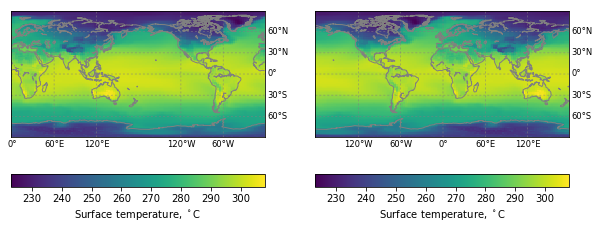

In [12]:
# Example: display result of applying xr_shift_lon to a Dataset
ds1 = f0_dict['input']
print('ds1 longitudes range from {} to {}'.format(*ds1['lon'].values[[0, -1]]))
ds2 = climapy.xr_shift_lon(ds1)
print('ds2 longitudes range from {} to {}'.format(*ds2['lon'].values[[0, -1]]))
# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
for ax, ds, title in zip(axs, [ds1, ds2], ['ds1 (unshifted)', 'ds2 (longitudes shifted)']):
    # Longitude and latitude values
    lon, lat = ds['lon'].values, ds['lat'].values
    lon0 = lon[0] - ((lon[1] - lon[0]) / 2.0)  # lower bound for first longitude bin
    lat0 = lat[0] - ((lat[1] - lat[0]) / 2.0)  # pseudo lower bound for first latitude bin
    # Set up map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(color='0.5')
    bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                      color='0.5', linewidth=0.5)
    bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                      color='0.5', linewidth=0.5)
    # Plot data and colour bar
    data = ds.isel(time=0)['TS'] - 273.15  # surface temperature in degC
    im = ax.imshow(ds.isel(time=0)['TS'].values, extent=[lon0, 360+lon0, -lat0, lat0])
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
    cbar.set_label('Surface temperature, $^\circ$C')

In [13]:
# Test 1: for Datasets, shift longitudes to a specified range then shift back
for key in f_dict.keys():
    print('key = {}'.format(key))
    if key == 'renamed':
        lon_name = 'longitude'
    else:
        lon_name = 'lon'
    for lon_min in [-180., -270., 0.]:  # try diff ranges
        print('  lon_min = {}'.format(lon_min))
        try:
            # Shift longitudes
            ds = climapy.xr_shift_lon(f0_dict[key], lon_min=lon_min, lon_name=lon_name)
            # Print information about original and new longitude values
            start_end_orig = tuple(f0_dict[key][lon_name].values[[0, -1]])  # original start and end lon values
            min_max_orig = tuple(np.sort(f0_dict[key][lon_name].values)[[0, -1]])  # original min and max lon values
            start_end_new = tuple(ds[lon_name].values[[0, -1]])  # new start and end lon values
            min_max_new = tuple(np.sort(ds[lon_name].values)[[0, -1]])  # new min and max lon values
            print('    [start, end]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]; '
                  '[min, max]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]'.format(*start_end_orig, *start_end_new,
                                                                            *min_max_orig, *min_max_new))
            # Shift longitudes back and check whether equal to original
            print('    Equal to original before shifting back? {}'.format(ds.equals(f0_dict[key])))
            ds = climapy.xr_shift_lon(ds, lon_min=min_max_orig[0], lon_name=lon_name)
            print('    Equal to original after shifting back? {}'.format(ds.equals(f0_dict[key])))
            if not ds.equals(f0_dict[key]):
                print('    Largest difference in lon values is '
                      '{}'.format(np.max(np.abs(ds['lon'].values - f0_dict[key]['lon'].values))))
                ds = ds.reindex_like(f0_dict[key], method='nearest', tolerance=1e-3)
                print('    Equal to original after re-indexing with tolerance? '
                      '{}'.format(ds.equals(f0_dict[key])))
        except ValueError:
            print('    Encountered ValueError')

key = input
  lon_min = -180.0
    [start, end]: [0.0, 357.5] -> [-180.0, 177.5]; [min, max]: [0.0, 357.5] -> [-180.0, 177.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [0.0, 357.5] -> [-270.0, 87.5]; [min, max]: [0.0, 357.5] -> [-270.0, 87.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = 0.0
    [start, end]: [0.0, 357.5] -> [0.0, 357.5]; [min, max]: [0.0, 357.5] -> [0.0, 357.5]
    Equal to original before shifting back? True
    Equal to original after shifting back? True
key = renamed
  lon_min = -180.0
    [start, end]: [0.0, 357.5] -> [-180.0, 177.5]; [min, max]: [0.0, 357.5] -> [-180.0, 177.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [0.0, 357.5] -> [-270.0, 87.5]; [min, max]: [0.0, 357.5] -> [-270.0, 87.5]
    Equal to original befo

In [14]:
# Test 2: for DataArrays, shift longitudes to a specified range then shift back
for key in f_dict.keys():
    print('key = {}'.format(key))
    if key == 'renamed':
        lon_name = 'longitude'
    else:
        lon_name = 'lon'
    for lon_min in [-180., -270., 0.]:  # try diff ranges
        print('  lon_min = {}'.format(lon_min))
        try:
            # Shift longitudes
            da = climapy.xr_shift_lon(f0_dict[key]['TS'], lon_min=lon_min, lon_name=lon_name)
            # Print information about original and new longitude values
            start_end_orig = tuple(f0_dict[key]['TS'][lon_name].values[[0, -1]])  # original start and end lon values
            min_max_orig = tuple(np.sort(f0_dict[key]['TS'][lon_name].values)[[0, -1]])  # original min and max lon values
            start_end_new = tuple(da[lon_name].values[[0, -1]])  # new start and end lon values
            min_max_new = tuple(np.sort(da[lon_name].values)[[0, -1]])  # new min and max lon values
            print('    [start, end]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]; '
                  '[min, max]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]'.format(*start_end_orig, *start_end_new,
                                                                            *min_max_orig, *min_max_new))
            # Shift longitudes back and check whether equal to original
            print('    Equal to original before shifting back? {}'.format(da.equals(f0_dict[key]['TS'])))
            da = climapy.xr_shift_lon(da, lon_min=min_max_orig[0], lon_name=lon_name)
            print('    Equal to original after shifting back? {}'.format(da.equals(f0_dict[key]['TS'])))
            if not da.equals(f0_dict[key]['TS']):
                print('    Largest difference in lon values is '
                      '{}'.format(np.max(np.abs(da['lon'].values - f0_dict[key]['TS']['lon'].values))))
                da = da.reindex_like(f0_dict[key]['TS'], method='nearest', tolerance=1e-3)
                print('    Equal to original after re-indexing with tolerance? '
                      '{}'.format(da.equals(f0_dict[key]['TS'])))
        except ValueError:
            print('    Encountered ValueError')

key = input
  lon_min = -180.0
    [start, end]: [0.0, 357.5] -> [-180.0, 177.5]; [min, max]: [0.0, 357.5] -> [-180.0, 177.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [0.0, 357.5] -> [-270.0, 87.5]; [min, max]: [0.0, 357.5] -> [-270.0, 87.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = 0.0
    [start, end]: [0.0, 357.5] -> [0.0, 357.5]; [min, max]: [0.0, 357.5] -> [0.0, 357.5]
    Equal to original before shifting back? True
    Equal to original after shifting back? True
key = renamed
  lon_min = -180.0
    [start, end]: [0.0, 357.5] -> [-180.0, 177.5]; [min, max]: [0.0, 357.5] -> [-180.0, 177.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [0.0, 357.5] -> [-270.0, 87.5]; [min, max]: [0.0, 357.5] -> [-270.0, 87.5]
    Equal to original befo

## Check that Datasets have not been modified in place

In [15]:
# Check that Datasets in f0_dict are unchanged
# Expected result: True for all
for key in f0_dict.keys():
    print('{} for {}'.format(f0_dict[key].identical(f0_dict_dc[key]), key))

True for input
True for renamed
True for reversed
True for transposed
True for irregular
True for strange


In [16]:
# Check that Datasets in fmean_dict are unchanged
# Expected result: True for all
for key in fmean_dict.keys():
    print('{} for {}'.format(fmean_dict[key].identical(fmean_dict_dc[key]), key))

True for input
True for renamed
True for reversed
True for transposed
True for irregular
True for strange
